In [3]:
import gc
import atexit
from io import BytesIO
import base64
import time
import logging
from flask import Flask, jsonify, request, Response, render_template, send_file, stream_with_context
from PIL import Image
from diffusers import DDIMScheduler
import torch
import numpy as np
import cv2  # Using OpenCV for video capture
from mmm_st.config import Config
from mmm_st.diffuse import get_transformer
from mmm_st.video import convert_to_pil_image

In [4]:

# Import and use configurations from an external module if necessary
class Config:
    HOST = '0.0.0.0'
    PORT = 8989
    CAP_PROPS = {'CAP_PROP_FPS': 30}
    TRANSFORM_TYPE = "kandinsky"
    NUM_STEPS = 20

class VideoStreamer:
    """ Continuously reads frames from a video capture source. """
    def __init__(self, device_path='/dev/video0'):
        self.cap = cv2.VideoCapture(device_path)
        if not self.cap.isOpened():
            print("Failed to open video source")
            raise ValueError("Video source cannot be opened")
        for prop, value in Config.CAP_PROPS.items():
            self.cap.set(getattr(cv2, prop), value)

    def get_current_frame(self):
        ret, frame = self.cap.read()
        if not ret:
            return None
        return Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    def release(self):
        self.cap.release()

# Shared global variables
current_prompt = None
path = '/dev/video0'
video_streamer = VideoStreamer(path) 
previous_frame= video_streamer.get_current_frame()
# image_transformer = get_transformer(Config.TRANSFORM_TYPE)(
#     num_steps=Config.NUM_STEPS,
# )
#print(f"IMAGE TFMER: {image_transformer}")


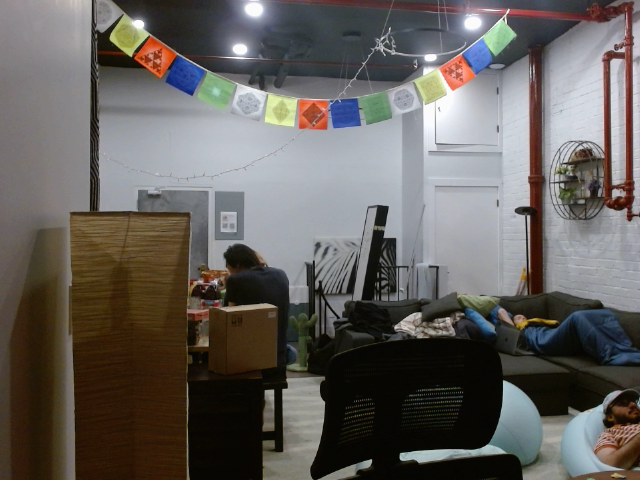

In [13]:
video_streamer.get_current_frame()

In [ ]:


def transform_frame(previous_frame, prompt=None):
    """
    Fetches a frame from the video streamer, applies a transformation based on the provided prompt,
    and interpolates it with the previous frame.
    
    Args:
        video_streamer (VideoStreamer): The video streamer object.
        image_transformer (Callable): Function to transform the frame based on the prompt.
        previous_frame (Image.Image): The previous frame to interpolate with.
        prompt (str, optional): The prompt based on which the transformation is applied.

    Returns:
        Image.Image: The updated frame after transformation and interpolation.
    """
    global video_streamer
    global image_transformer
    #print('frame getting...')
    current_frame = video_streamer.get_current_frame()
    #print('frame got')
    if current_frame is None:
        #print('camera frame is none!')
        return previous_frame  # Return the previous frame if no new frame is captured

    #print('calling tfm...')
    if prompt:
        # Transform the current frame based on the prompt
        try:
            transformed_image = image_transformer(current_frame, prompt)
        except Exception as e:
            raise e
    else:
        transformed_image = current_frame

    # Interpolate between the previous frame and the transformed image
    if previous_frame is not None:
        output_frame = interpolate_images(previous_frame, transformed_image, alpha=0.75)
    else:
        output_frame = transformed_image

    return output_frame


def interpolate_images(image1, image2, alpha=0.5):
    """ Interpolates two images with a given alpha blending factor. """
    if image1.size != image2.size:
        image2 = image2.resize(image1.size)
    return Image.blend(image1, image2, alpha)


@app.route('/')
def index():
    return render_template('index.html')


@app.route('/set_prompt', methods=['POST'])
def set_prompt():
    global current_prompt
    prompt = request.json.get('prompt')
    if not prompt:
        return jsonify({"error": "Prompt is required"}), 400
    current_prompt = prompt
    return jsonify({"message": "Prompt set successfully"})


@app.route('/stream')
def stream():
    def generate():
        global current_prompt
        global video_streamer
        global image_transformer
        global previous_frame

        try:
            while True:
                #print("frame tfm")
                output_frame = transform_frame(
                    previous_frame, 
                    prompt=current_prompt)
                previous_frame = output_frame

                # # set the new image as the previous, to condition on
                # image_transformer.set_image(previous_frame)
                
                img_byte_arr = BytesIO()
                pil_image = convert_to_pil_image(output_frame)
                pil_image.save(img_byte_arr, format='JPEG')
                img_byte_arr.seek(0)
                encoded_img = base64.b64encode(img_byte_arr.getvalue()).decode('utf-8')
                yield f"data: {encoded_img}\n\n"
                time.sleep(1 / 30)  # Control frame rate
        finally:
            video_streamer.release()

    return Response(stream_with_context(generate()), mimetype='text/event-stream')

def cleanup():
    print("Application is shutting down. Cleaning up resources.")
    global video_streamer
    global image_transformer
    del image_transformer
    video_streamer.release()
    gc.collect()
    torch.cuda.empty_cache()

# if __name__ == "__main__":
#     atexit.register(cleanup)
#     app.run(
#         host=Config.HOST, 
#         port=Config.PORT,
#         debug=True, 
#         threaded=True, 
#         use_reloader=False,
#     )
